# Mesh Tutorial 4: Neighbors, Adjacency, and Spatial Queries

This tutorial covers how to find neighbors and perform spatial queries:

1. **Topological Neighbors**: Neighbors based on mesh connectivity
2. **Adjacency Data Structures**: Efficient sparse encoding
3. **Spatial Queries with BVH**: Point containment and nearest-cell search
4. **Sampling**: Random points on cells, data interpolation

---

## Why This Matters for Physics-AI

- **Graph Neural Networks**: Need adjacency information for message passing
- **Data Augmentation**: Sample random points for training
- **Field Interpolation**: Query values at arbitrary locations
- **Collision Detection**: Find which cells contain query points

In [1]:
import torch

from physicsnemo.mesh import Mesh
from physicsnemo.mesh.primitives.surfaces import sphere_icosahedral
from physicsnemo.mesh.primitives.planar import unit_square

## Section 1: Topological Neighbors

Topological neighbors are determined by mesh connectivity (which elements share vertices/edges),
not by spatial distance.

PhysicsNeMo-Mesh provides four adjacency queries:

| Method | Returns | Description |
|--------|---------|-------------|
| `get_point_to_points_adjacency()` | Points → Points | Graph edges (mesh skeleton) |
| `get_point_to_cells_adjacency()` | Points → Cells | Vertex star (cells containing each point) |
| `get_cell_to_cells_adjacency()` | Cells → Cells | Cells sharing a facet |
| `get_cell_to_points_adjacency()` | Cells → Points | Vertices of each cell |

### Point-to-Points (Graph Edges)

In [2]:
mesh = sphere_icosahedral.load(subdivisions=1)
print(f"Mesh: {mesh.n_points} points, {mesh.n_cells} cells")

# Get adjacency: which points are connected to each point?
adj = mesh.get_point_to_points_adjacency()

# Convert to list-of-lists for inspection
neighbors_list = adj.to_list()

print(f"\nNeighbors of point 0: {neighbors_list[0]}")
print(f"Neighbors of point 1: {neighbors_list[1]}")
print(f"Neighbors of point 2: {neighbors_list[2]}")

Mesh: 42 points, 80 cells

Neighbors of point 0: [12, 13, 14, 15, 16]
Neighbors of point 1: [12, 17, 18, 19, 20]
Neighbors of point 2: [21, 22, 23, 24, 25]


In [3]:
# Check vertex valence (number of neighbors)
valences = [len(n) for n in neighbors_list]
print(f"Valence distribution:")
for v in sorted(set(valences)):
    count = valences.count(v)
    print(f"  Valence {v}: {count} vertices")

Valence distribution:
  Valence 5: 12 vertices
  Valence 6: 30 vertices


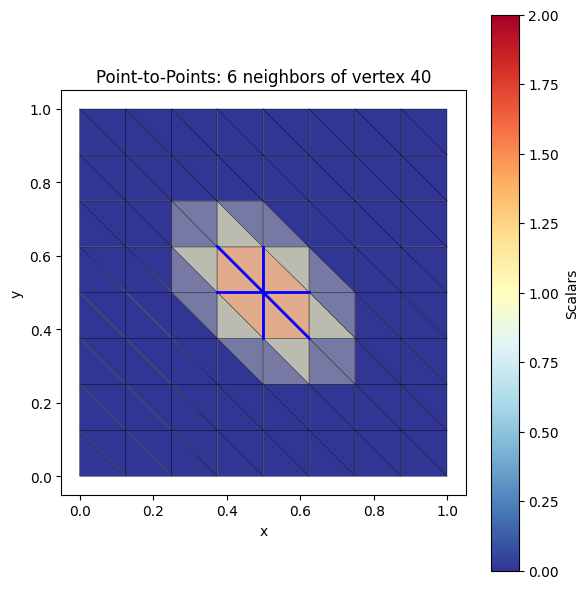

In [4]:
import matplotlib.pyplot as plt

# Visualize point-to-points adjacency on a 2D mesh for clarity
viz_mesh = unit_square.load(subdivisions=3)
pts = viz_mesh.points.numpy()

# Pick an interior point and get its neighbors
highlight_idx = 40  # at (0.5, 0.5)
adj_viz = viz_mesh.get_point_to_points_adjacency()
neighbor_indices = adj_viz.to_list()[highlight_idx]

# Build a point scalar: 0=other, 1=neighbor, 2=query point
highlight = torch.zeros(viz_mesh.n_points)
highlight[neighbor_indices] = 1.0
highlight[highlight_idx] = 2.0

fig, ax = plt.subplots(figsize=(6, 6))
viz_mesh.draw(
    point_scalars=highlight,
    cmap="RdYlBu_r",
    vmin=0,
    vmax=2,
    show=False,
    ax=ax,
    backend="matplotlib",
)

# Overlay adjacency edges connecting the query point to its neighbors
for ni in neighbor_indices:
    ax.plot(
        [pts[highlight_idx, 0], pts[ni, 0]],
        [pts[highlight_idx, 1], pts[ni, 1]],
        "b-",
        lw=2,
        zorder=10,
    )

ax.set_title(
    f"Point-to-Points: {len(neighbor_indices)} neighbors of vertex {highlight_idx}"
)
plt.tight_layout()
plt.show()

### Point-to-Cells (Vertex Star)

In [5]:
# Which cells contain each point?
adj_p2c = mesh.get_point_to_cells_adjacency()
cells_per_point = adj_p2c.to_list()

print(f"Cells containing point 0: {cells_per_point[0]}")
print(f"Cells containing point 1: {cells_per_point[1]}")

# Number of cells per vertex
n_cells_per_point = [len(c) for c in cells_per_point]
print(f"\nMean cells per vertex: {sum(n_cells_per_point) / len(n_cells_per_point):.1f}")

Cells containing point 0: [0, 4, 8, 12, 16]
Cells containing point 1: [6, 9, 20, 37, 78]

Mean cells per vertex: 5.7


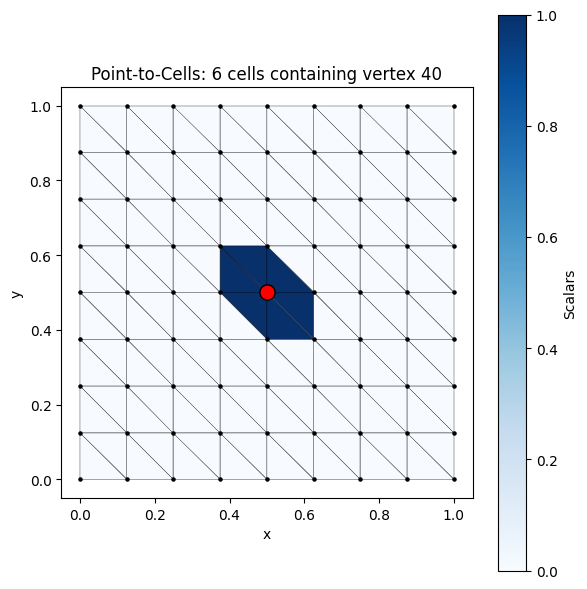

In [6]:
# Visualize the vertex star: cells containing a point
adj_p2c_viz = viz_mesh.get_point_to_cells_adjacency()
star_cells = adj_p2c_viz.to_list()[highlight_idx]

# Build a cell scalar: 0=other, 1=star cell
star_highlight = torch.zeros(viz_mesh.n_cells)
star_highlight[star_cells] = 1.0

fig, ax = plt.subplots(figsize=(6, 6))
viz_mesh.draw(
    cell_scalars=star_highlight,
    cmap="Blues",
    vmin=0,
    vmax=1,
    show=False,
    ax=ax,
    backend="matplotlib",
)

# Overlay the query point
ax.scatter(
    pts[highlight_idx, 0],
    pts[highlight_idx, 1],
    c="red",
    s=120,
    zorder=10,
    edgecolors="black",
)
ax.set_title(
    f"Point-to-Cells: {len(star_cells)} cells containing vertex {highlight_idx}"
)
plt.tight_layout()
plt.show()

### Cell-to-Cells (Shared Facets)

In [7]:
# Which cells share a facet (edge for triangles, face for tetrahedra)?
adj_c2c = mesh.get_cell_to_cells_adjacency(adjacency_codimension=1)
cell_neighbors = adj_c2c.to_list()

print(f"Neighbors of cell 0: {cell_neighbors[0]}")
print(f"Neighbors of cell 1: {cell_neighbors[1]}")

# For triangles, each cell has up to 3 neighbors (one per edge)
n_neighbors = [len(n) for n in cell_neighbors]
print(f"\nNeighbor count distribution:")
for n in sorted(set(n_neighbors)):
    count = n_neighbors.count(n)
    print(f"  {n} neighbors: {count} cells")

Neighbors of cell 0: [3, 4, 16]
Neighbors of cell 1: [3, 18, 25]

Neighbor count distribution:
  3 neighbors: 80 cells


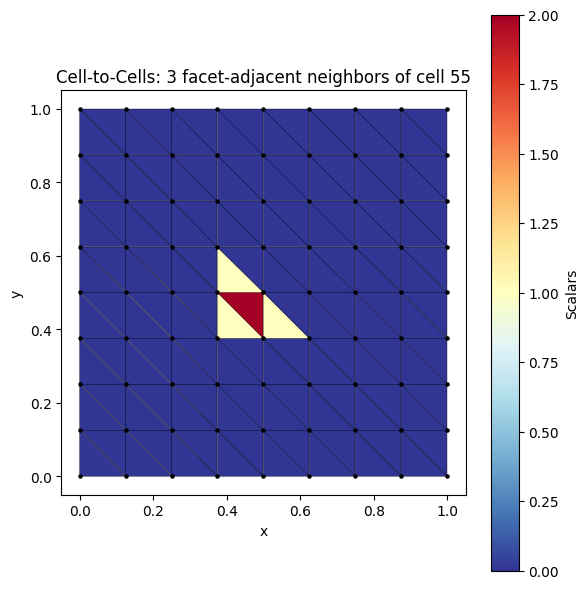

In [8]:
# Visualize cell-to-cells adjacency
highlight_cell = 55  # near center of the 2D mesh
adj_c2c_viz = viz_mesh.get_cell_to_cells_adjacency(adjacency_codimension=1)
cell_nbrs = adj_c2c_viz.to_list()[highlight_cell]

# Build a cell scalar: 0=other, 1=neighbor, 2=query cell
cell_highlight = torch.zeros(viz_mesh.n_cells)
cell_highlight[cell_nbrs] = 1.0
cell_highlight[highlight_cell] = 2.0

fig, ax = plt.subplots(figsize=(6, 6))
viz_mesh.draw(
    cell_scalars=cell_highlight,
    cmap="RdYlBu_r",
    vmin=0,
    vmax=2,
    show=False,
    ax=ax,
    backend="matplotlib",
)
ax.set_title(
    f"Cell-to-Cells: {len(cell_nbrs)} facet-adjacent neighbors of cell {highlight_cell}"
)
plt.tight_layout()
plt.show()

### Cells-to-Points (Cell Vertices)

In [9]:
# Which points define each cell?
adj_c2p = mesh.get_cell_to_points_adjacency()
cell_vertices = adj_c2p.to_list()

print(f"Vertices of cell 0: {cell_vertices[0]}")
print(f"Vertices of cell 1: {cell_vertices[1]}")

# This is essentially the cells tensor in list form
print(f"\nCompare to mesh.cells[0]: {mesh.cells[0].tolist()}")

Vertices of cell 0: [0, 16, 13]
Vertices of cell 1: [11, 34, 16]

Compare to mesh.cells[0]: [0, 16, 13]


## Section 2: Adjacency Data Structure

Internally, PhysicsNeMo-Mesh uses an efficient sparse encoding:

- **indices**: Flat array of all neighbor indices
- **offsets**: Start position in `indices` for each element

This is the same format used by PyTorch Geometric (CSR-style).

In [10]:
mesh = sphere_icosahedral.load(subdivisions=2)
adj = mesh.get_point_to_points_adjacency()

print(f"Adjacency object: {adj}")
print(f"\nIndices shape: {adj.indices.shape}")
print(f"Offsets shape: {adj.offsets.shape}")

Adjacency object: Adjacency(
    indices=Tensor(shape=torch.Size([960]), device=cpu, dtype=torch.int64, is_shared=False),
    offsets=Tensor(shape=torch.Size([163]), device=cpu, dtype=torch.int64, is_shared=False),
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)

Indices shape: torch.Size([960])
Offsets shape: torch.Size([163])


In [11]:
# How to read the sparse format:
# Neighbors of point i are: indices[offsets[i]:offsets[i+1]]

i = 5  # Example point
start = adj.offsets[i].item()
end = adj.offsets[i + 1].item()
neighbors = adj.indices[start:end]

print(f"Point {i} neighbors (sparse): {neighbors.tolist()}")
print(f"Point {i} neighbors (list):   {adj.to_list()[i]}")

Point 5 neighbors (sparse): [67, 68, 69, 70, 71]
Point 5 neighbors (list):   [67, 68, 69, 70, 71]


### Converting to PyTorch Geometric Format

For GNN libraries, you often need edge indices in COO format.

In [12]:
# The Adjacency object provides expand_to_pairs() for direct COO conversion
adj = mesh.get_point_to_points_adjacency()
source, target = adj.expand_to_pairs()
edge_index = torch.stack([source, target], dim=0)

print(f"edge_index shape: {edge_index.shape}")
print(f"Number of directed edges: {edge_index.shape[1]}")
print(f"\nFirst 10 edges:")
print(edge_index[:, :10])

edge_index shape: torch.Size([2, 960])
Number of directed edges: 960

First 10 edges:
tensor([[ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1],
        [42, 43, 44, 45, 46, 47, 48, 49, 50, 51]])


## Section 3: Spatial Queries with BVH

For spatial queries (which cells contain a point? what's the nearest cell?),
PhysicsNeMo-Mesh provides a Bounding Volume Hierarchy (BVH).

BVH enables O(log N) query time instead of O(N) brute-force.

In [13]:
from physicsnemo.mesh.spatial import BVH

# Create a 2D mesh for clear visualization
mesh = unit_square.load(subdivisions=4)
print(f"Mesh: {mesh.n_cells} cells")

# Build BVH
bvh = BVH.from_mesh(mesh)
print(f"\nBVH: {bvh.n_nodes} nodes")

Mesh: 512 cells

BVH: 127 nodes


In [14]:
# Query: which cells might contain these points?
query_points = torch.tensor(
    [
        [0.25, 0.25],  # Inside mesh
        [0.5, 0.5],  # Center
        [0.75, 0.75],  # Inside mesh
        [1.5, 1.5],  # Outside mesh
    ]
)

candidates = bvh.find_candidate_cells(query_points)

# Use the counts property for efficient per-query candidate counts
for i, (pt, count) in enumerate(zip(query_points, candidates.counts)):
    print(f"Point {pt.tolist()}: {count.item()} candidate cells")

Point [0.25, 0.25]: 32 candidate cells
Point [0.5, 0.5]: 32 candidate cells
Point [0.75, 0.75]: 32 candidate cells
Point [1.5, 1.5]: 0 candidate cells


### Point Containment

Find which cell(s) actually contain each query point.

In [15]:
from physicsnemo.mesh.sampling.sample_data import find_containing_cells

# Find containing cells (returns first containing cell for each point)
cell_indices, bary_coords = find_containing_cells(mesh, query_points)

print("Point containment results:")
for i, (pt, cell_idx) in enumerate(zip(query_points, cell_indices)):
    if cell_idx >= 0:
        print(f"  {pt.tolist()} -> cell {cell_idx.item()}")
    else:
        print(f"  {pt.tolist()} -> outside mesh")

Point containment results:
  [0.25, 0.25] -> cell 103
  [0.5, 0.5] -> cell 239
  [0.75, 0.75] -> cell 375
  [1.5, 1.5] -> outside mesh


In [16]:
# The barycentric coordinates tell you where in the cell the point is
print("\nBarycentric coordinates:")
for i, (pt, bary) in enumerate(zip(query_points, bary_coords)):
    if not bary.isnan().any():
        print(f"  {pt.tolist()}: {bary.tolist()}")
    else:
        print(f"  {pt.tolist()}: outside (NaN)")


Barycentric coordinates:
  [0.25, 0.25]: [0.0, 1.0, -0.0]
  [0.5, 0.5]: [0.0, 1.0, -0.0]
  [0.75, 0.75]: [0.0, 1.0, -0.0]
  [1.5, 1.5]: outside (NaN)


/tmp/ipykernel_135832/3654304560.py:16: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


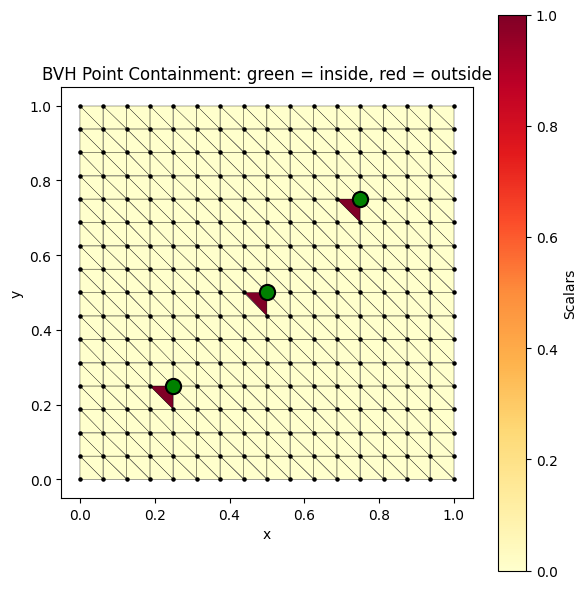

In [17]:
# Visualize point containment results
contain_highlight = torch.zeros(mesh.n_cells)
for ci in cell_indices:
    if ci >= 0:
        contain_highlight[ci] = 1.0

fig, ax = plt.subplots(figsize=(6, 6))
mesh.draw(
    cell_scalars=contain_highlight,
    cmap="YlOrRd",
    vmin=0,
    vmax=1,
    show=False,
    ax=ax,
    backend="matplotlib",
)

# Overlay query points: green=inside, red X=outside
for pt, ci in zip(query_points, cell_indices):
    color, marker = ("green", "o") if ci >= 0 else ("red", "x")
    ax.scatter(
        pt[0].item(),
        pt[1].item(),
        c=color,
        s=120,
        marker=marker,
        zorder=10,
        edgecolors="black",
        linewidths=1.5,
    )

ax.set_title("BVH Point Containment: green = inside, red = outside")
plt.tight_layout()
plt.show()

## Section 4: Sampling Points on Meshes

PhysicsNeMo-Mesh can sample random points on mesh cells and interpolate data at those points.

**Common use cases:**
- **Upsampling model predictions**: An AI model predicts values at mesh vertices, but you need
  values at arbitrary points (e.g., sensor locations that don't align with the mesh)
- **Data augmentation**: Generate training samples at random locations within cells, not just
  at vertices, for better generalization
- **Field comparison**: Interpolate predictions from one mesh onto another mesh's points for
  error computation
- **Monte Carlo integration**: Sample points uniformly over a surface for numerical integration

### Random Point Sampling

In [18]:
mesh = sphere_icosahedral.load(subdivisions=2)

# Sample one random point per cell (default)
random_points = mesh.sample_random_points_on_cells()
print(f"Random points shape: {random_points.shape}")
print(f"  (one point per cell, in 3D space)")

Random points shape: torch.Size([320, 3])
  (one point per cell, in 3D space)


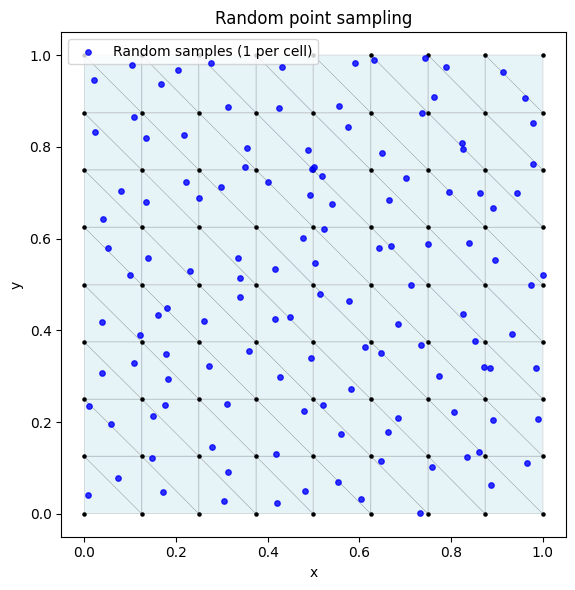

In [19]:
# Visualize random samples on a 2D mesh
viz_mesh = unit_square.load(subdivisions=3)
random_pts = viz_mesh.sample_random_points_on_cells()

fig, ax = plt.subplots(figsize=(6, 6))
viz_mesh.draw(show=False, ax=ax, backend="matplotlib", alpha_cells=0.3)

# Overlay sampled points
rp = random_pts.numpy()
vp = viz_mesh.points.numpy()
ax.scatter(
    rp[:, 0],
    rp[:, 1],
    c="blue",
    s=15,
    alpha=0.8,
    zorder=10,
    label="Random samples (1 per cell)",
)
ax.legend(loc="upper left")
ax.set_title("Random point sampling")
plt.tight_layout()
plt.show()

In [20]:
# Sample multiple points from specific cells
# Sample 5 points from cell 0, 3 points from cell 1, 2 points from cell 2
cell_indices = torch.tensor([0, 0, 0, 0, 0, 1, 1, 1, 2, 2])
random_points = mesh.sample_random_points_on_cells(cell_indices=cell_indices)

print(f"Sampled {len(random_points)} points")
print(f"Points from cell 0:\n{random_points[:5]}")

Sampled 10 points
Points from cell 0:
tensor([[-0.6136,  0.7725,  0.0976],
        [-0.5540,  0.8127,  0.1021],
        [-0.5883,  0.7935,  0.0775],
        [-0.4886,  0.8535,  0.1248],
        [-0.6026,  0.7819,  0.0873]])


In [21]:
# Control the distribution with alpha parameter
# alpha=1.0 (default): uniform over the cell
# alpha>1: concentrated toward center
# alpha<1: concentrated toward edges/vertices

cell_indices = torch.zeros(100, dtype=torch.long)  # Sample 100 points from cell 0

uniform = mesh.sample_random_points_on_cells(cell_indices=cell_indices, alpha=1.0)
centered = mesh.sample_random_points_on_cells(cell_indices=cell_indices, alpha=5.0)

print(f"Uniform sampling std: {uniform.std(dim=0)}")
print(f"Centered sampling std: {centered.std(dim=0)}")

Uniform sampling std: tensor([0.0529, 0.0364, 0.0506])
Centered sampling std: tensor([0.0253, 0.0168, 0.0245])


### Data Interpolation at Query Points

In [22]:
# Create a mesh with data
mesh = unit_square.load(subdivisions=4)
mesh.point_data["temperature"] = mesh.points[:, 0] + mesh.points[:, 1]  # T = x + y
mesh.cell_data["pressure"] = torch.randn(mesh.n_cells)

# Query points inside the mesh
query_points = torch.tensor(
    [
        [0.25, 0.25],
        [0.5, 0.5],
        [0.75, 0.25],
    ]
)

# Sample point data (interpolated using barycentric coordinates)
sampled_point_data = mesh.sample_data_at_points(query_points, data_source="points")
print("Interpolated point data:")
print(f"  Temperature at query points: {sampled_point_data['temperature']}")
print(f"  Expected (x + y): {query_points.sum(dim=-1)}")

Interpolated point data:
  Temperature at query points: tensor([0.5000, 1.0000, 1.0000])
  Expected (x + y): tensor([0.5000, 1.0000, 1.0000])


In [23]:
# Sample cell data (no interpolation, just cell value)
sampled_cell_data = mesh.sample_data_at_points(query_points, data_source="cells")
print("Cell data at query points:")
print(f"  Pressure: {sampled_cell_data['pressure']}")

Cell data at query points:
  Pressure: tensor([ 0.0630, -0.2767,  0.1286])


### Handling Points Outside the Mesh

In [24]:
# Query points including some outside
query_points = torch.tensor(
    [
        [0.5, 0.5],  # Inside
        [1.5, 0.5],  # Outside
        [-0.1, 0.5],  # Outside
    ]
)

# Default behavior: NaN for points outside
sampled = mesh.sample_data_at_points(query_points, data_source="points")
print(f"Temperature (with NaN for outside): {sampled['temperature']}")

Temperature (with NaN for outside): tensor([1., nan, nan])


In [25]:
# Alternative: project to nearest cell first
sampled_projected = mesh.sample_data_at_points(
    query_points, data_source="points", project_onto_nearest_cell=True
)
print(f"Temperature (projected): {sampled_projected['temperature']}")

Temperature (projected): tensor([1.0417, 1.3333, 0.5417])


## Summary

In this tutorial, you learned about mesh queries:

1. **Topological Neighbors**:
   - `get_point_to_points_adjacency()` - graph edges
   - `get_point_to_cells_adjacency()` - vertex star
   - `get_cell_to_cells_adjacency()` - cell neighbors

2. **Adjacency Format**: Sparse `(indices, offsets)` encoding, with `expand_to_pairs()` for
   direct conversion to PyTorch Geometric COO format

3. **Spatial Queries**:
   - `BVH.from_mesh()` - build acceleration structure
   - `find_containing_cells()` - point-in-cell test

4. **Sampling**:
   - `sample_random_points_on_cells()` - random point generation
   - `sample_data_at_points()` - data interpolation at arbitrary locations